# Feature Activation Heatmaps

This notebook visualizes feature activation patterns across bias prompts.

**Purpose:**
- Show which features activate for which types of prompts
- Identify patterns in feature activation across demographics
- Visualize sparsity and activation magnitudes

**Input Data:**
- SAE feature activations: [N_prompts × 100,000]
- Top bias features from IG² attribution

**Output:**
- Heatmap of activations [prompts × features]
- Sparsity analysis
- Clustering visualization

In [1]:
import os
import sys
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm import tqdm

PROJECT_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJECT_ROOT))

from src.visualization import (
    setup_korean_font,
    load_demographics,
    load_ig2_results,
    load_activations,
    load_sae_decoder_weights,
    plot_activation_heatmap,
    select_top_features_union,
    get_demographic_labels
)
from src.models.sae import GatedAutoEncoder, AutoEncoder

print(f"Project root: {PROJECT_ROOT}")

/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /home/youngjins/project/global_ai_frontier


In [2]:
# Setup
setup_korean_font()
sns.set_style('white')

Font configured: ['Noto Sans CJK KR']


In [3]:
# Configuration
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
ASSETS_DIR = PROJECT_ROOT / "notebooks" / "visualizations" / "assets"
ASSETS_DIR.mkdir(exist_ok=True, parents=True)

# Stage: 'pilot', 'medium', or 'full'
STAGE = "pilot"

# SAE configuration
SAE_TYPE = "gated"  # 'standard' or 'gated'
LAYER_QUANTILE = "q2"  # 'q1', 'q2', or 'q3'

# Demographic to analyze (None = analyze all)
DEMOGRAPHIC = None  # e.g., "성별", "인종", etc.

# Visualization parameters
TOP_K = 50  # Top features per demographic

print(f"Stage: {STAGE}")
print(f"SAE type: {SAE_TYPE}")
print(f"Layer quantile: {LAYER_QUANTILE}")
print(f"Demographic: {DEMOGRAPHIC or 'all'}")
print(f"Top-K: {TOP_K}")

Stage: pilot
SAE type: gated
Layer quantile: q2
Demographic: all
Top-K: 50


## Load Data

In [4]:
# Load demographics
demographics_dict = load_demographics(DATA_DIR)
demographic_labels_ko, _ = get_demographic_labels(demographics_dict)

# Load IG² results (loads from all per-demographic directories)
ig2_results = load_ig2_results(RESULTS_DIR, stage=STAGE, demographic=DEMOGRAPHIC)

print(f"IG² results loaded for {len(ig2_results)} demographics")
for demo in ig2_results.keys():
    print(f"  - {demo}")

IG² results loaded for 9 demographics
  - 외모
  - 성적지향
  - 정치성향
  - 직업
  - 종교
  - 경제수준
  - 성별
  - 인종
  - 나이


## Load Activations and Compute SAE Features

In [5]:
# Load activations from pickle file
# If DEMOGRAPHIC is specified, load from per-demographic directory
if DEMOGRAPHIC:
    activations, labels, prompts = load_activations(
        RESULTS_DIR, stage=STAGE, demographic=DEMOGRAPHIC, layer_quantile=LAYER_QUANTILE
    )
else:
    # Load from first available demographic
    first_demo = list(ig2_results.keys())[0]
    activations, labels, prompts = load_activations(
        RESULTS_DIR, stage=STAGE, demographic=first_demo, layer_quantile=LAYER_QUANTILE
    )
    print(f"Loaded activations from demographic: {first_demo}")

print(f"Activations shape: {activations.shape}")
print(f"Number of samples: {len(labels)}")

Loaded activations from demographic: 외모
Activations shape: torch.Size([30, 4096])
Number of samples: 30


In [6]:
# Load SAE model and compute features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sae_path = RESULTS_DIR / "models" / f"sae-{SAE_TYPE}_{STAGE}_{LAYER_QUANTILE}" / "model.pth"

if not sae_path.exists():
    raise FileNotFoundError(f"SAE model not found at {sae_path}. Please run 03_train_sae.py first.")

print(f"Loading SAE from {sae_path}")
if SAE_TYPE == 'gated':
    sae = GatedAutoEncoder.from_pretrained(str(sae_path))
else:
    sae = AutoEncoder.from_pretrained(str(sae_path))

sae.to(device)
sae.eval()

print(f"SAE loaded: dict_size={sae.dict_size}, activation_dim={sae.activation_dim}")

Loading SAE from /home/youngjins/project/global_ai_frontier/results/models/sae-gated_pilot_q2/model.pth
SAE loaded: dict_size=100000, activation_dim=4096


In [7]:
# Extract SAE features from activations
n_samples = len(activations)
features = torch.zeros(n_samples, sae.dict_size)

print(f"Extracting SAE features for {n_samples} samples...")

with torch.no_grad():
    for i in tqdm(range(n_samples), desc="Extracting features"):
        sample = activations[i].unsqueeze(0).to(device)
        _, feat = sae(sample, output_features=True)
        features[i] = feat[0].cpu()

# Create prompt_ids
prompt_ids = [f"prompt_{i}" for i in range(n_samples)]

print(f"\nFeature activations shape: {features.shape}")
print(f"Number of prompts: {len(prompt_ids)}")

# Clean up SAE from GPU memory
del sae
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Extracting SAE features for 30 samples...


Extracting features: 100%|██████████| 30/30 [00:02<00:00, 13.72it/s]


Feature activations shape: torch.Size([30, 100000])
Number of prompts: 30


## Select Top Features

In [8]:
# Select union of top features across demographics
all_top_features, demographic2topfeatures = select_top_features_union(
    ig2_results, top_k=TOP_K
)

print(f"Total unique features selected: {len(all_top_features)}")
print(f"Features per demographic: {TOP_K}")

Total unique features selected: 210
Features per demographic: 50


## Plot Activation Heatmap

/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:238: UserWarning: Glyph 54200 (\N{HANGUL SYLLABLE PYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:238: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:238: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:238: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier/src/visualization/plotting_utils.py:238: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/youngjins/project/global_ai_frontier

Saved to /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets/activation_heatmap_pilot_top50.png


/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54200 (\N{HANGUL SYLLABLE PYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packag

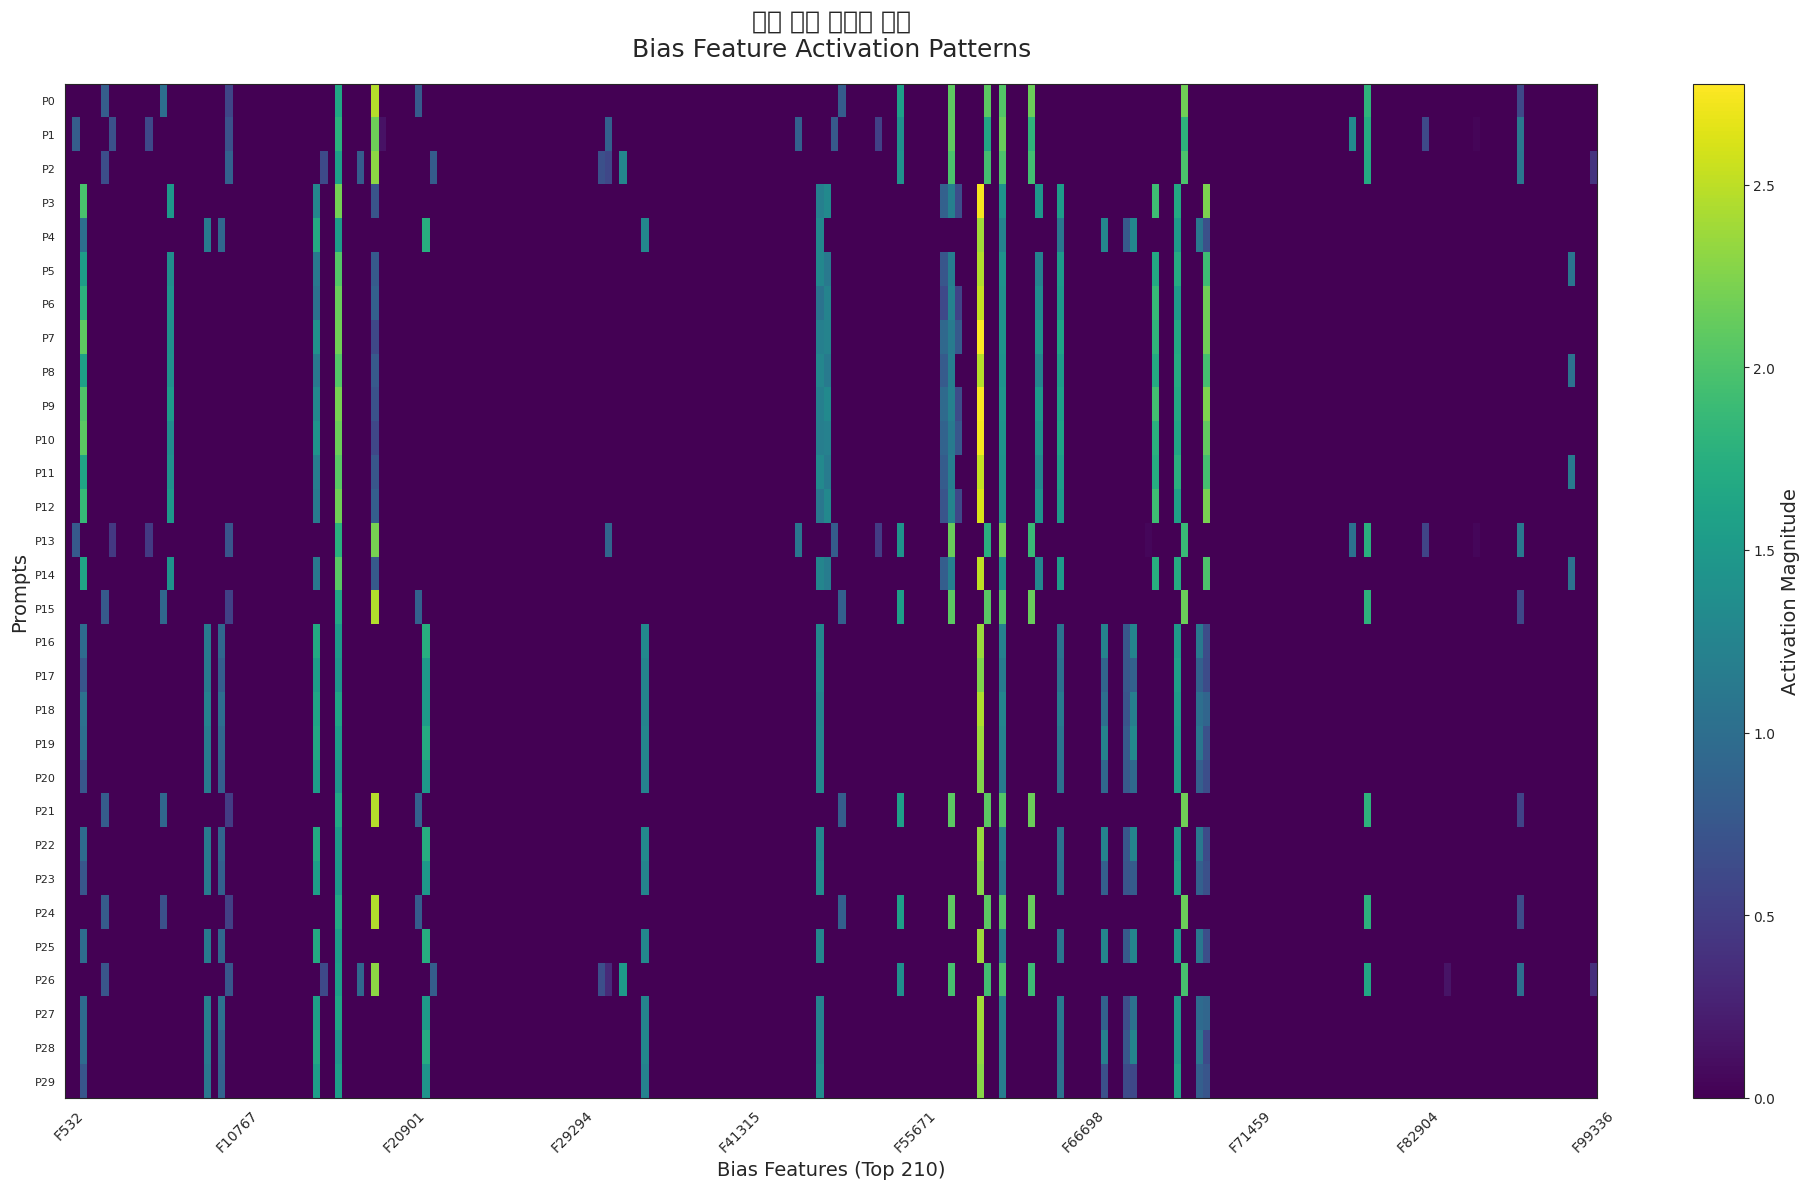

In [9]:
# Create heatmap
fig = plot_activation_heatmap(
    feature_activations=features,
    selected_features=all_top_features,
    prompt_labels=[f"P{i}" for i in range(len(features))],
    save_path=ASSETS_DIR / f"activation_heatmap_{STAGE}_top{TOP_K}.png",
    figsize=(20, 12),
    cmap='viridis'
)

plt.show()

## Sparsity Analysis

Overall sparsity: 99.98%
Mean per-feature sparsity: 99.98%
Median per-feature sparsity: 100.00%


/tmp/ipykernel_25028/1361591939.py:31: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/1361591939.py:31: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/1361591939.py:31: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/1361591939.py:31: UserWarning: Glyph 55148 (\N{HANGUL SYLLABLE HYI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/1361591939.py:31: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/1361591939.py:31: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/1361591939.py:31: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  p

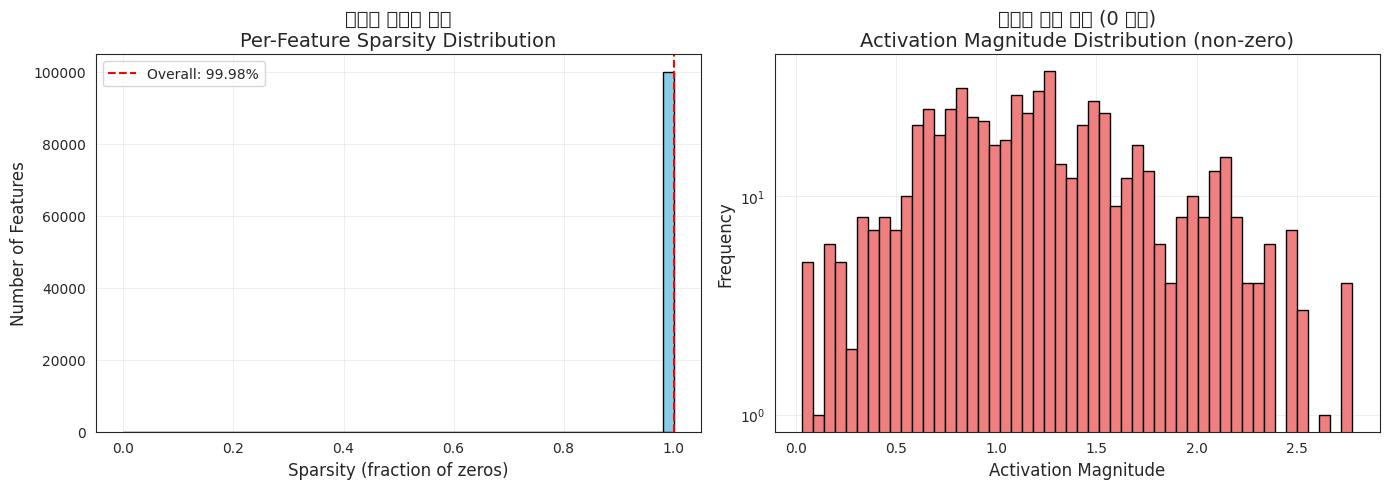

In [10]:
from src.visualization.feature_selection import compute_feature_sparsity

# Compute sparsity
overall_sparsity, per_feature_sparsity = compute_feature_sparsity(features)

print(f"Overall sparsity: {overall_sparsity:.2%}")
print(f"Mean per-feature sparsity: {per_feature_sparsity.mean():.2%}")
print(f"Median per-feature sparsity: {per_feature_sparsity.median():.2%}")

# Plot sparsity distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of per-feature sparsity
axes[0].hist(per_feature_sparsity.cpu().numpy(), bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(overall_sparsity, color='red', linestyle='--', label=f'Overall: {overall_sparsity:.2%}')
axes[0].set_xlabel('Sparsity (fraction of zeros)', fontsize=12)
axes[0].set_ylabel('Number of Features', fontsize=12)
axes[0].set_title('특성별 희소성 분포\nPer-Feature Sparsity Distribution', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Activation magnitude distribution (non-zero only)
non_zero_activations = features[features > 0]
axes[1].hist(non_zero_activations.cpu().numpy(), bins=50, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Activation Magnitude', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('활성화 크기 분포 (0 제외)\nActivation Magnitude Distribution (non-zero)', fontsize=14)
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ASSETS_DIR / f"sparsity_analysis_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

## Feature Activation Frequency

/tmp/ipykernel_25028/2316034535.py:20: UserWarning: Glyph 54200 (\N{HANGUL SYLLABLE PYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/2316034535.py:20: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/2316034535.py:20: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/2316034535.py:20: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/2316034535.py:20: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/2316034535.py:20: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/2316034535.py:20: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans

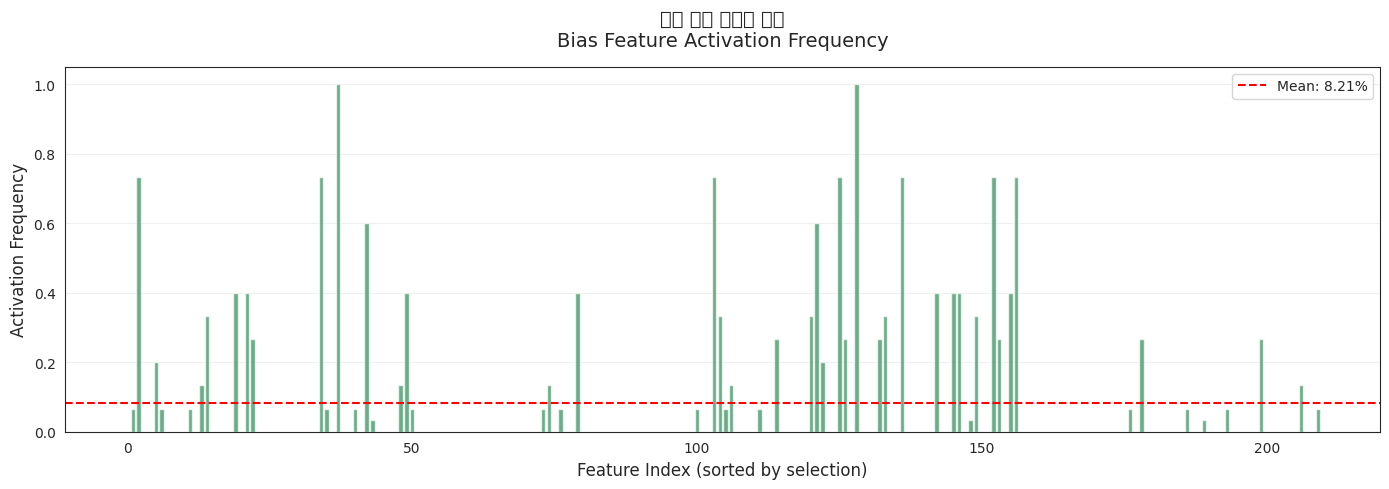


Activation Frequency Statistics:
  Mean: 8.21%
  Median: 0.00%
  Min: 0.00%
  Max: 100.00%


In [11]:
# Compute activation frequency for top features
selected_features = features[:, all_top_features]
activation_freq = (selected_features > 0).float().mean(dim=0)

# Plot
fig, ax = plt.subplots(figsize=(14, 5))

x = np.arange(len(all_top_features))
ax.bar(x, activation_freq.cpu().numpy(), color='seagreen', alpha=0.7)
ax.set_xlabel('Feature Index (sorted by selection)', fontsize=12)
ax.set_ylabel('Activation Frequency', fontsize=12)
ax.set_title('편향 특성 활성화 빈도\nBias Feature Activation Frequency', fontsize=14, pad=15)
ax.grid(axis='y', alpha=0.3)

# Add mean line
ax.axhline(activation_freq.mean().item(), color='red', linestyle='--', 
           label=f'Mean: {activation_freq.mean():.2%}')
ax.legend()

plt.tight_layout()
plt.savefig(ASSETS_DIR / f"activation_frequency_{STAGE}_top{TOP_K}.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nActivation Frequency Statistics:")
print(f"  Mean: {activation_freq.mean():.2%}")
print(f"  Median: {activation_freq.median():.2%}")
print(f"  Min: {activation_freq.min():.2%}")
print(f"  Max: {activation_freq.max():.2%}")

## Clustered Heatmap

/tmp/ipykernel_25028/915236422.py:37: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/915236422.py:37: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/915236422.py:37: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/915236422.py:37: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/915236422.py:37: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/915236422.py:37: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_25028/915236422.py:37: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.ti

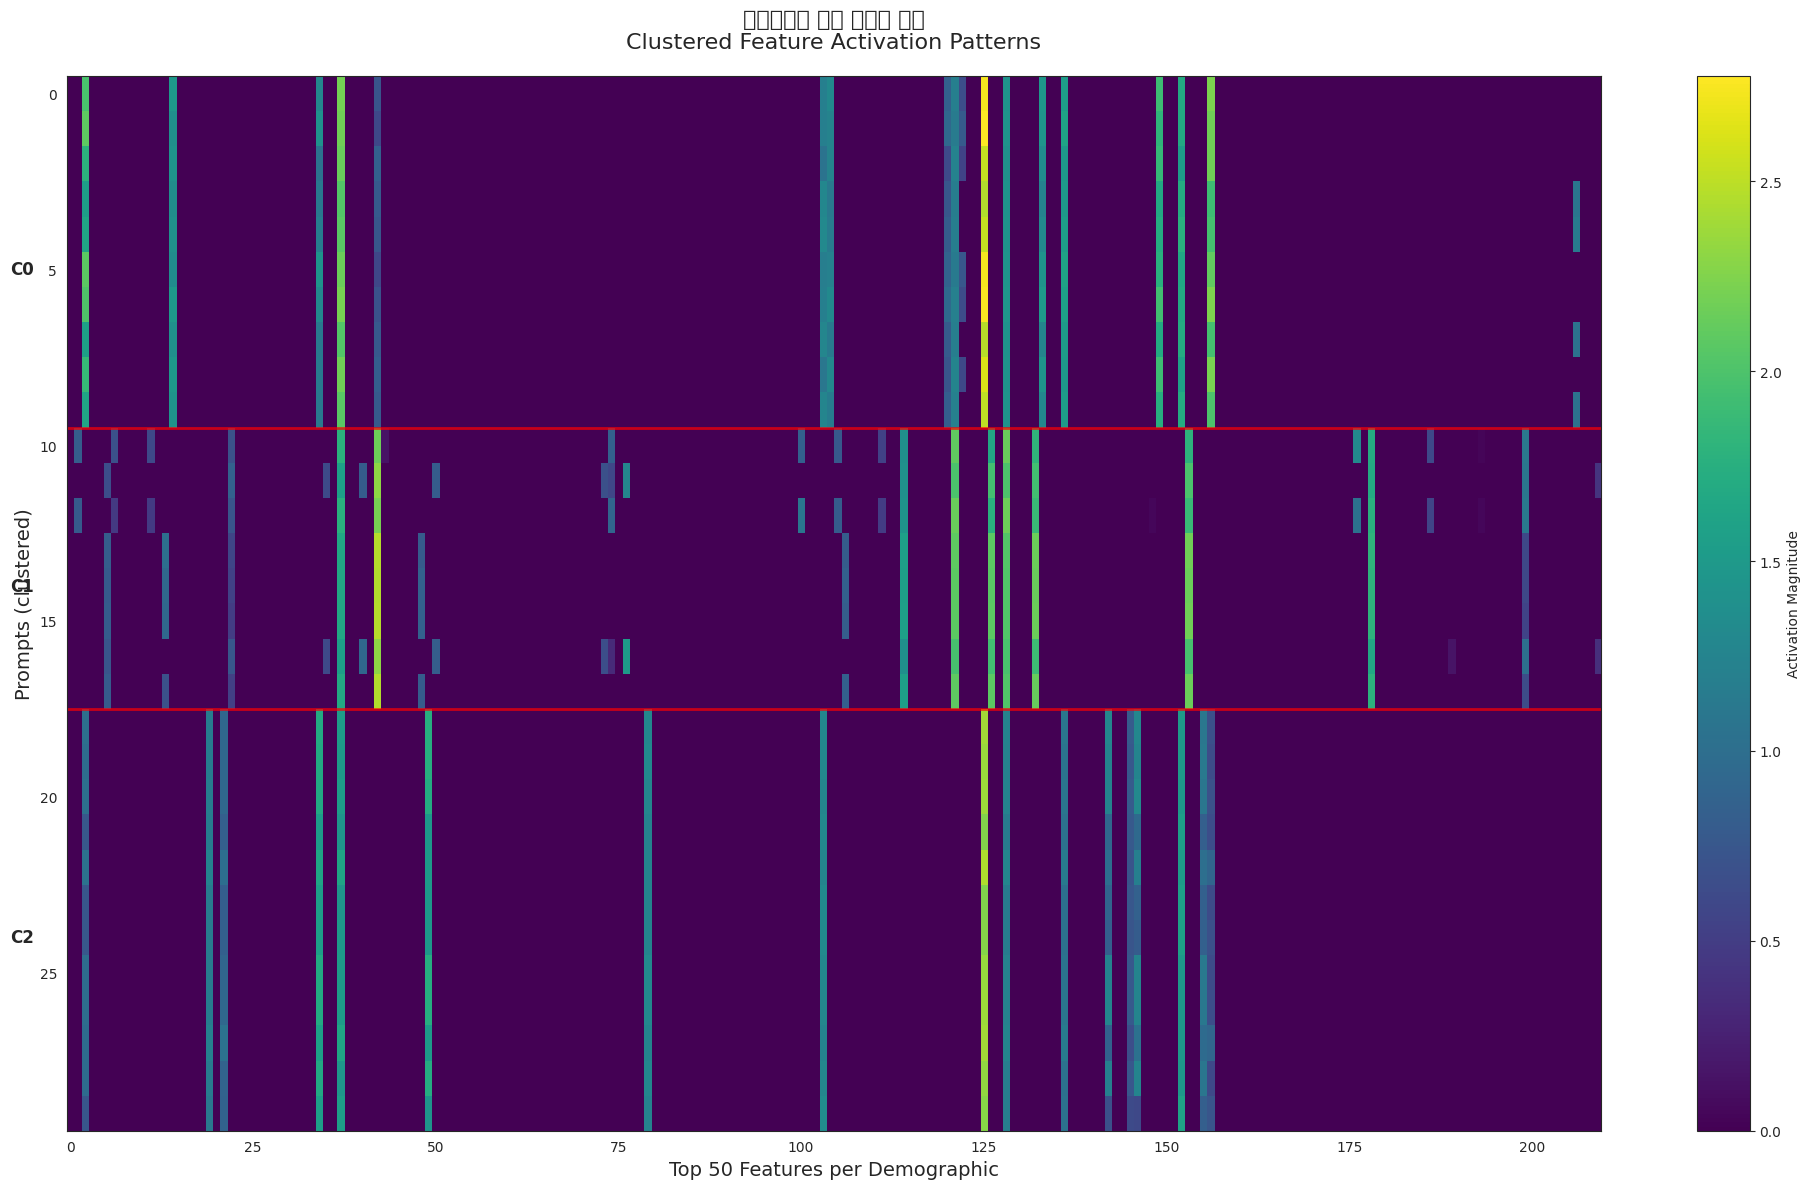


Clustered 30 prompts into 3 groups
  Cluster 0: 10 prompts
  Cluster 1: 8 prompts
  Cluster 2: 12 prompts


In [12]:
# Cluster prompts by activation patterns
n_clusters = min(5, len(features) // 10)

if len(features) >= n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(selected_features.cpu().numpy())
    
    # Sort by cluster
    sort_idx = np.argsort(cluster_labels)
    sorted_features = selected_features[sort_idx]
    sorted_labels = cluster_labels[sort_idx]
    
    # Plot
    fig, ax = plt.subplots(figsize=(20, 12))
    
    im = ax.imshow(sorted_features.cpu().numpy(), aspect='auto', cmap='viridis', interpolation='nearest')
    
    # Add cluster boundaries
    boundaries = [0]
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i] != sorted_labels[i-1]:
            boundaries.append(i)
            ax.axhline(i - 0.5, color='red', linewidth=2, alpha=0.7)
    boundaries.append(len(sorted_labels))
    
    # Add cluster labels
    for i in range(len(boundaries) - 1):
        mid = (boundaries[i] + boundaries[i+1]) / 2
        ax.text(-5, mid, f'C{i}', va='center', ha='right', fontsize=12, fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Activation Magnitude')
    ax.set_xlabel(f'Top {TOP_K} Features per Demographic', fontsize=14)
    ax.set_ylabel('Prompts (clustered)', fontsize=14)
    ax.set_title('클러스터된 특성 활성화 패턴\nClustered Feature Activation Patterns', 
                 fontsize=16, pad=20)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"clustered_activation_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nClustered {len(features)} prompts into {n_clusters} groups")
    for i in range(n_clusters):
        count = (cluster_labels == i).sum()
        print(f"  Cluster {i}: {count} prompts")
else:
    print(f"Not enough prompts for clustering (have {len(features)}, need ≥{n_clusters})")

## Interpretation

### What to Look For:

1. **Activation Patterns:**
   - Are certain features consistently active across prompts?
   - Are there prompt-specific feature activations?
   - Do features cluster together in activation?

2. **Sparsity:**
   - Is the target sparsity (95-99%) achieved?
   - Are some features more sparse than others?
   - What is the distribution of non-zero activations?

3. **Clustering:**
   - Do prompts group by demographic dimension?
   - Are there distinct activation profiles?
   - Which features are shared vs. unique across clusters?

### Next Steps:

1. Test manipulation effects on high-frequency features
2. Investigate features with unusual activation patterns
3. Correlate activation patterns with bias scores